Steane code single qubit error sensitivity
=================================

Sets up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474.

Use this to estimate the simulation sensitivity to single qubit errors.

The necessary function modules are imported , including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    mean_of_list,
    calculate_standard_error
    )

Define constants so the process flow can be controlled from one place:

In [2]:
NOISE = True                             #Test with noise
SHOTS = 10000                            #Number of shots to run    
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0204           #Two gate noise
ITERATIONS = 25
FACTOR = [1, 0, 2]

SIMULATOR = Aer.get_backend('qasm_simulator')

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = ['0001111',
                       '0110011',
                       '1010101'
                      ]

The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the string is reversed compared to the normal output of Qiskit.

In [4]:
codewords = ['0000000',
             '1010101',
             '0110011',
             '1100110',
             '0001111',
             '1011010',
             '0111100',
             '1101001'
            ]

Encoding set up
-----------------------
The encoding circuit alone is set up and either transpiled to the native gate set for the Ion computer, or calculated with the standard quiskit noise gate set.

In [5]:
print(f'Run with {SHOTS} shots and {ITERATIONS} iterations')
for factor in FACTOR:
    single_gate_depolarising = SINGLE_GATE_DEPOLARISING * factor
    print(f'With single gate depolarising noise of {single_gate_depolarising:.7f}')
    for reduced in [True]:
        if reduced:
            print('Reduced encoding gates used')
        else:
            print('Full encoding gates used')
        for ion_gate_set in [True]:
            results_list = []
            if ion_gate_set:
                print('Results after transpilation to ion computer gate set')   
            else:
                print('Results without transpilation')
            for iteration in range(ITERATIONS):
                qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ancilla = False)
                qubit.set_up_logical_zero(0)
                qubit.barrier()
                if ion_gate_set:
                    SINGLE_GATE_SET = ['id', 'ry', 'rx']
                    TWO_GATE_SET = ['rxx']
                else:
                    SINGLE_GATE_SET = ['id', 'h', 'x', 'y', 'z,']
                    TWO_GATE_SET = ['cx', 'cz']    
                BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET
                if NOISE:
                    noise_model = get_noise(MEASURE_NOISE, single_gate_depolarising, 
                                            TWO_GATE_DEPOLARISING, 
                                           SINGLE_GATE_SET, TWO_GATE_SET)
                #print('noise_model',noise_model)
                qubit.logical_measure_data()
                qubit.barrier()
                if ion_gate_set:
                    qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
                    if NOISE:
                        result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
                    else:
                        result = execute(qt, SIMULATOR, shots = SHOTS).result()
                    counts = result.get_counts(qt)
                    #print(counts)
                else:
                    if NOISE:
                        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
                    else:
                        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
                    counts = result.get_counts(qubit)
                    #print(counts)
                count_valid, count_invalid = count_valid_output_strings(counts, codewords)
                invalid_rate = count_invalid / SHOTS
                results_list.append(invalid_rate)
                #print(f'There were {count_valid} valid output strings and {count_invalid} invalid output string')
                #print(f'Invalid strings occurred on {invalid_rate:.4f} of runs')
            mean = mean_of_list(results_list)
            standard_deviation, standard_error = calculate_standard_error(results_list)
            print()
            print(f' Over all iterations invalid strings occurred on {mean:.4f} of runs')
            print(f' The standard deviation {standard_deviation:.4f} and the standard error is {standard_error:.4f}')
            print()

Run with 10000 shots and 25 iterations
With single gate depolarising noise of 0.0003660
Reduced encoding gates used
Results after transpilation to ion computer gate set

 Over all iterations invalid strings occurred on 0.1800 of runs
 The standard deviation 0.0043 and the standard error is 0.0009

With single gate depolarising noise of 0.0000000
Reduced encoding gates used
Results after transpilation to ion computer gate set

 Over all iterations invalid strings occurred on 0.1776 of runs
 The standard deviation 0.0038 and the standard error is 0.0008

With single gate depolarising noise of 0.0007320
Reduced encoding gates used
Results after transpilation to ion computer gate set

 Over all iterations invalid strings occurred on 0.1841 of runs
 The standard deviation 0.0042 and the standard error is 0.0008



Draw last circuit processed:

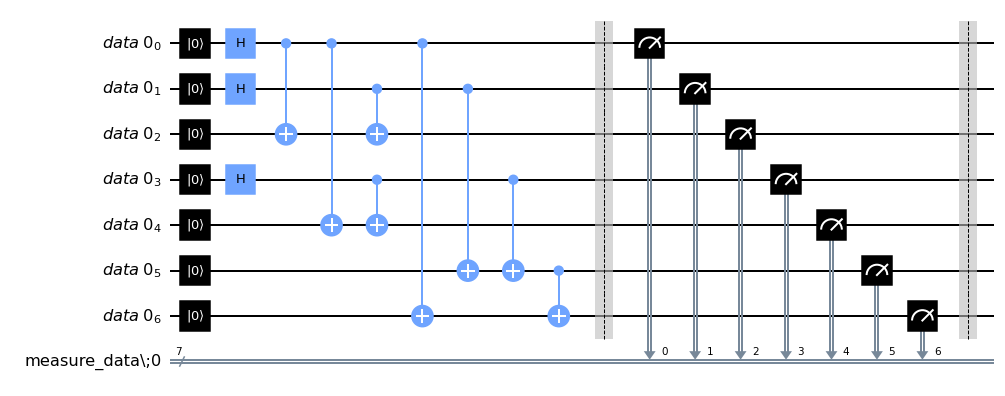

In [6]:
qubit.draw(output = 'mpl', filename = 'Steane_code_encoding_circuit.jpg', fold = 30)

Draw last transpiled circuit processed

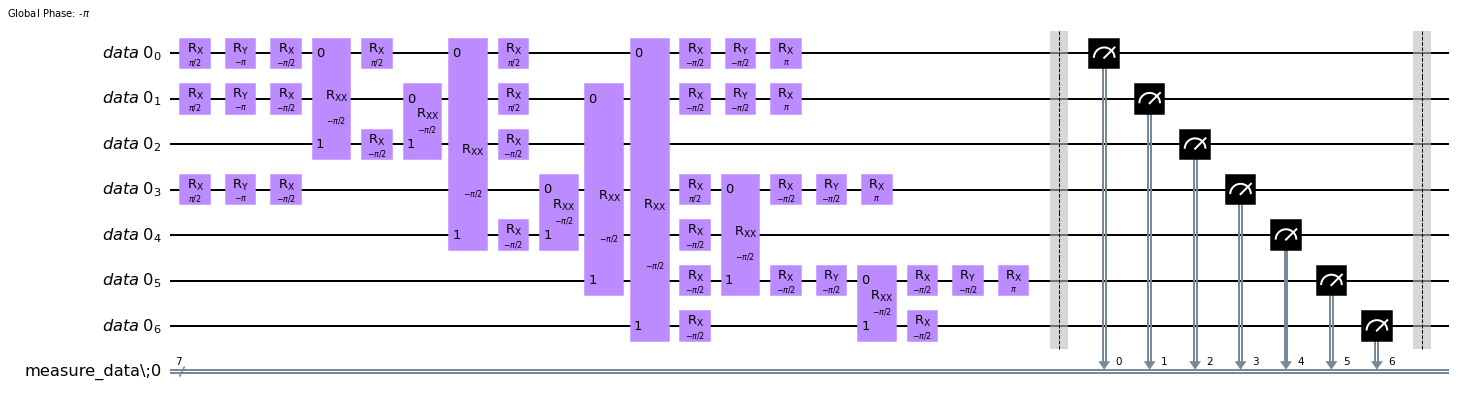

In [7]:
qt.draw(output = 'mpl', filename = 'Steane_code_encoding_circuit_transpiled.jpg', fold = 40)